In [1]:
from SpykeTorch import utils
from torchvision import transforms
from MozafariDeep import *

# These settings define the 6 DoG Kernels described in the paper that are used to
#    generate the six feature maps in the Intensity to Latency encoding layer.
kernels = [ utils.DoGKernel(window_size=3,sigma1=3/9,sigma2=6/9),
            utils.DoGKernel(window_size=3,sigma1=6/9,sigma2=3/9),
            utils.DoGKernel(window_size=7,sigma1=7/9,sigma2=14/9),
            utils.DoGKernel(window_size=7,sigma1=14/9,sigma2=7/9),
            utils.DoGKernel(window_size=13,sigma1=13/9,sigma2=26/9),
            utils.DoGKernel(window_size=13,sigma1=26/9,sigma2=13/9)]
filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)

In [2]:
#
# Load the MNIST datasets, apply the s1c1 transformation filter as the data sets are loaded and 
#    leverage the CacheDataset wrapper to improve performance.
#
data_root = "data"
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = s1c1))
MNIST_testLoader = DataLoader(MNIST_test, batch_size=len(MNIST_test), shuffle=False)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1, shuffle=True)

In [3]:
# Get a single batch from the DataLoader
dataiter = iter(MNIST_testLoader)
images, labels = next(dataiter)

0


The shape of the tensor is described as follows:  

images[batch_size][time_step][feature][height][width]

In [4]:
print(images.shape)

torch.Size([1, 15, 6, 28, 28])


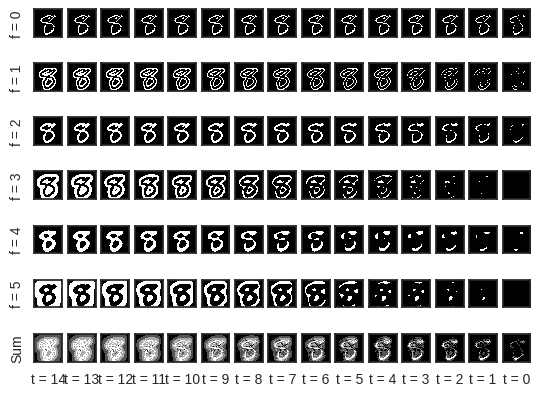

In [5]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-white')
plt_idx = 0
# For each feature (channel)
for f in range(6):
    # For each timestep
    for t in range(15):
        # image = images[0][t].permute(1,2,0)
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = images[0][t]
        plt_idx += 1
        ax = plt.subplot(7, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 5:
            ax = plt.subplot(7, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

In [6]:
#
# Initialize the network
#
mozafari = MozafariMNIST2018()

In [7]:
#
# Setup CUDA
#
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    if use_cuda:
        print("Activating CUDA on network")
        mozafari.cuda()
else:
    print("CUDA is not available")

NVIDIA GeForce GTX 1650 SUPER
Activating CUDA on network


In [8]:
print("DoG Image Spikewave transferred to CUDA")
dog_spike_wave = images.cuda()

DoG Image Spikewave transferred to CUDA


In [9]:
print("Load the fully trained Mozafari Deep SNN")
if os.path.isfile("MozafariDeep/saved.net"):
    mozafari.load_state_dict(torch.load(f="saved.net",weights_only=False))
    mozafari.eval()
else:
    print("Pre-trained network is not available for first convolutional layer.")



Load the fully trained Mozafari Deep SNN


## Convolutional Layer 1
Load the previously trained Convolutional Layer and examine the recognized features on our test image.

In [10]:
#
# Process The First Convolutional Layer
#

spike_wave,potentials = mozafari(dog_spike_wave[0],max_layer=Layer.Conv1)

The shape of the spike wave generated after Conv1 is described as follows:  

spike_wave[time_step][feature][height][width]

In [11]:
print(spike_wave.shape)

torch.Size([15, 30, 28, 28])


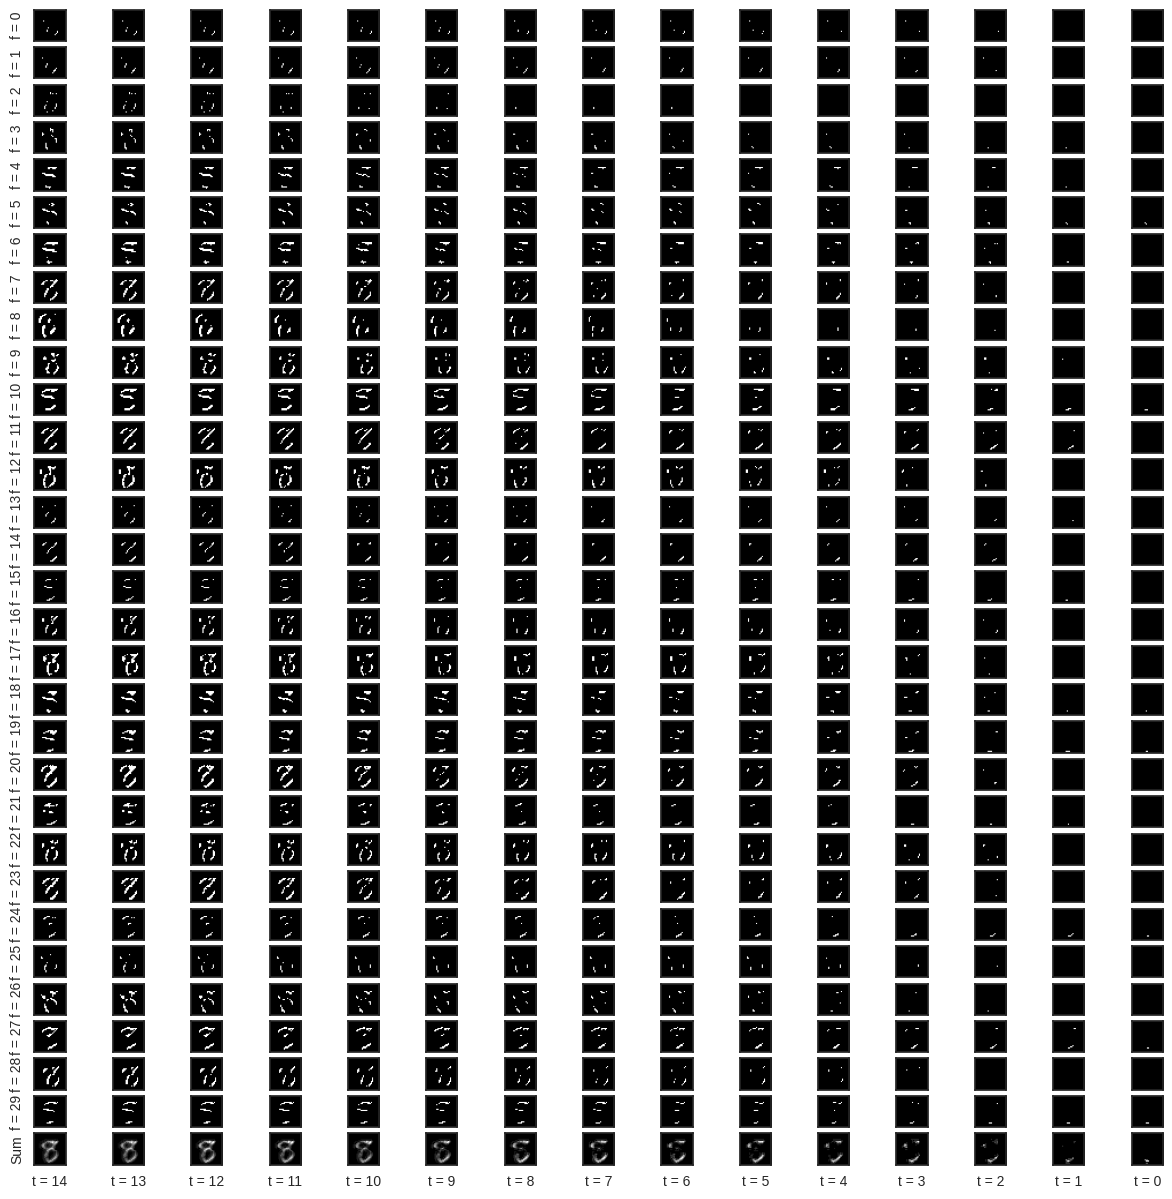

In [12]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,15)
plt_idx = 0
# For each feature (channel)
display_wave = spike_wave.cpu()
for f in range(30):
    # For each timestep
    for t in range(15):
        # image = images[0][t].permute(1,2,0)
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(31, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 29:
            ax = plt.subplot(31, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

In [13]:
## Pooling Layer 1

In [14]:
#
# Process The First Pooling Layer
#

spike_wave = mozafari(dog_spike_wave[0],max_layer=Layer.Pool1)


The shape of the spike_wave generated by Pool1 (after padding)

In [15]:
print(spike_wave.shape)

torch.Size([15, 30, 16, 16])


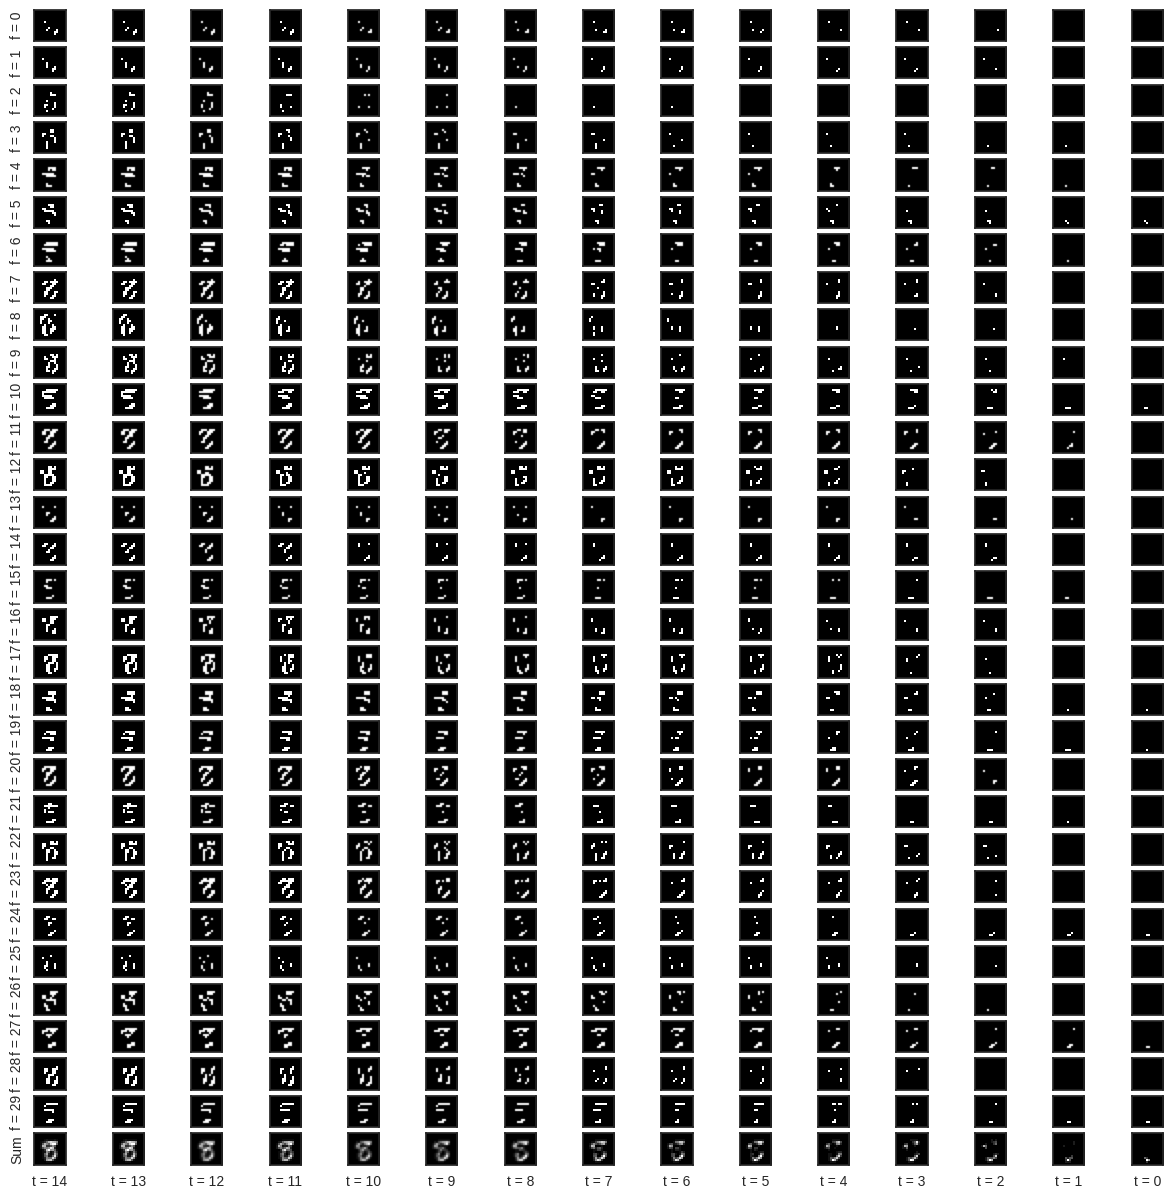

In [16]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,15)
plt_idx = 0
# For each feature (channel)
display_wave = spike_wave.cpu()
for f in range(30):
    # For each timestep
    for t in range(15):
        # image = images[0][t].permute(1,2,0)
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(31, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 29:
            ax = plt.subplot(31, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

In [17]:
## Convolutional Layer 2

In [18]:
#
# Process The Second Convolutional Layer
#

spike_wave,potentials = mozafari(dog_spike_wave[0],max_layer=Layer.Conv2)


The shape of the spike wave generated after Conv2 is described as follows:  

spike_wave[time_step][feature][height][width]

In [19]:
print(spike_wave.shape)

torch.Size([15, 250, 14, 14])


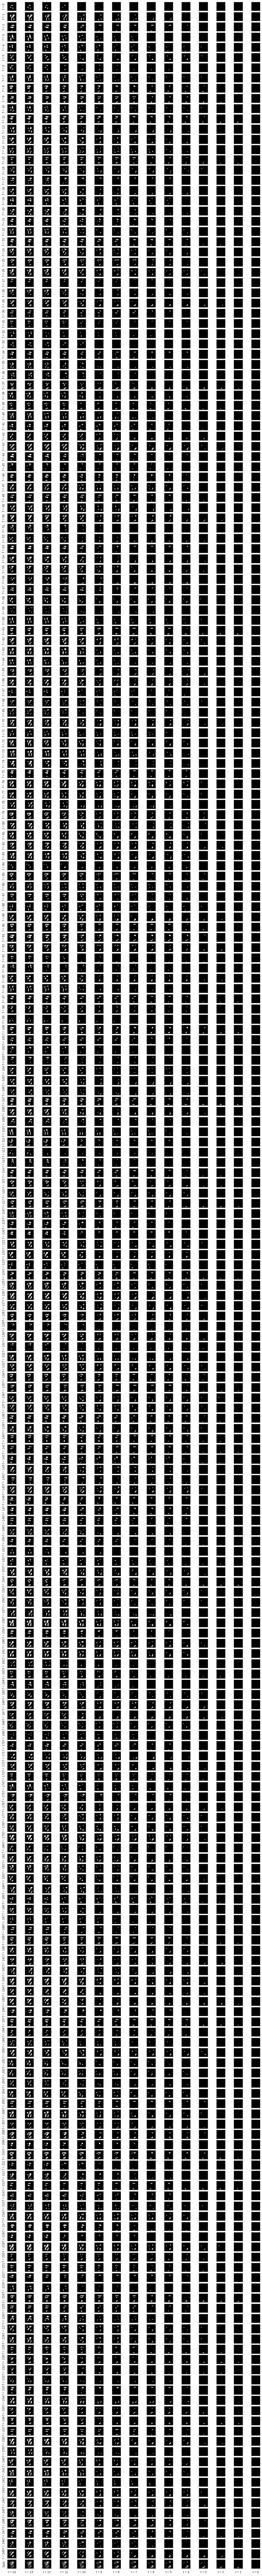

In [20]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,150)
plt_idx = 0
# For each feature (channel)
display_wave = spike_wave.cpu()
for f in range(250):
    # For each timestep
    for t in range(15):
        # image = images[0][t].permute(1,2,0)
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(251, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 249:
            ax = plt.subplot(251, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

In [21]:
## Pooling Layer 2

In [22]:
#
# Process The Second Pooling Layer
#

spike_wave = mozafari(dog_spike_wave[0],max_layer=Layer.Pool2)


The shape of the spike_wave generated by Pool2 (after padding)

In [23]:
print(spike_wave.shape)

torch.Size([15, 250, 8, 8])


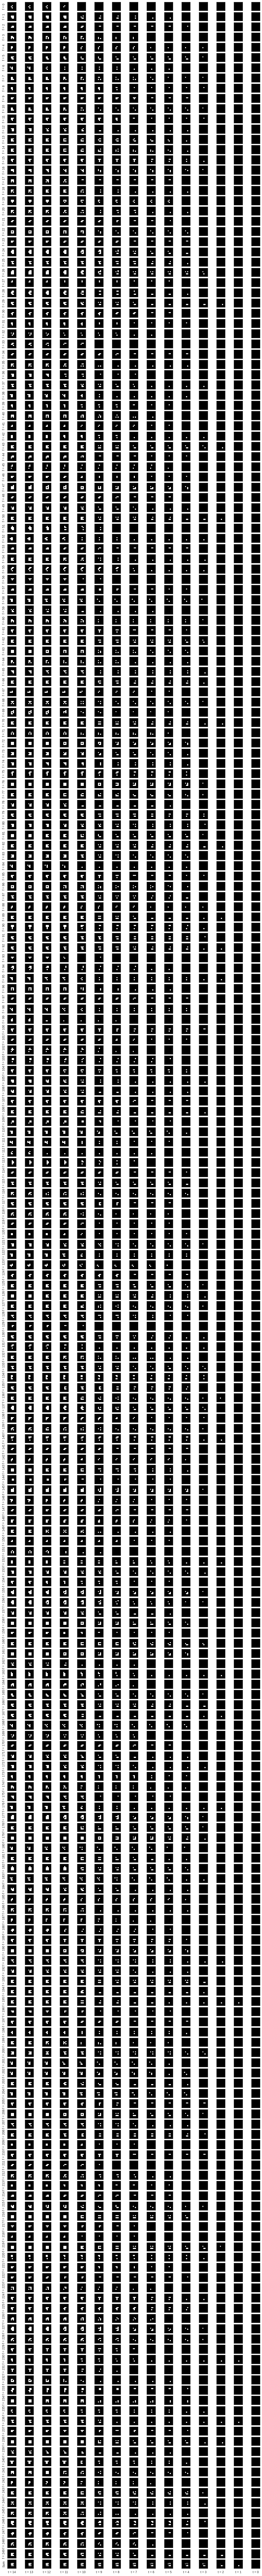

In [24]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,150)
plt_idx = 0
# For each feature (channel)
display_wave = spike_wave.cpu()
for f in range(250):
    # For each timestep
    for t in range(15):
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(251, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel('f = ' + str(f))
           
        plt.imshow(image[f],cmap='gray')
        if f == 249:
            ax = plt.subplot(251, 15, plt_idx + 15)
            plt.setp(ax, xticklabels=[])
            plt.setp(ax, yticklabels=[])
            if t == 14:
                ax.set_ylabel('Sum')
            ax.set_xlabel('t = ' + str(t))
            plt.imshow(image.sum(dim=0).numpy(),cmap='gray')
plt.show()

In [25]:
## Convolutional Layer 3

In [35]:
#
# Process The Third Convolutional Layer
#

spike_wave = mozafari(dog_spike_wave[0],max_layer=Layer.Conv3)


The shape of the spike wave generated after Conv2 is described as follows:  

spike_wave[time_step][feature][height][width]

In [36]:
print(spike_wave.shape)

torch.Size([15, 200, 4, 4])


In [38]:
conv3_spike_wave = sf.pad(spike_wave, (1,1,1,1))
display_wave = conv3_spike_wave.cpu()

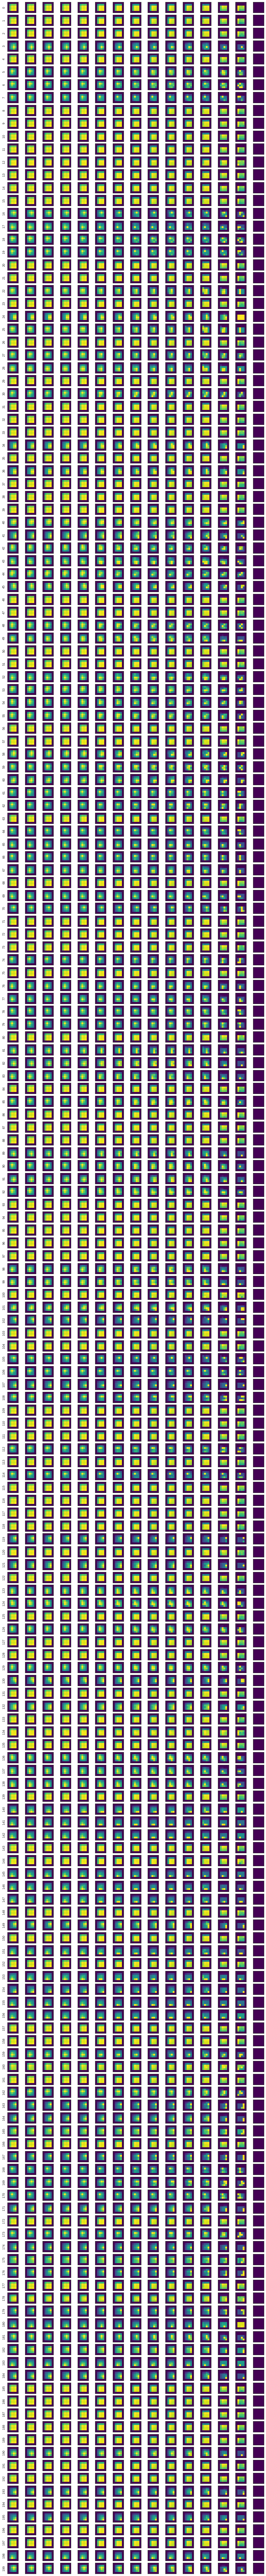

In [40]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams["figure.figsize"] = (15,150)
plt_idx = 0
# For each feature (channel)
# display_wave = spike_wave.cpu()
for f in range(200):
    # For each timestep
    for t in range(15):
        # Reverse the direction of the spike wave in time
        t = 14 - t
        image = display_wave[t]
        plt_idx += 1
        ax = plt.subplot(201, 15, plt_idx)
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        if t == 14:
            ax.set_ylabel(str(f))
            
        plt.imshow(image[f],cmap='viridis')
plt.show()

In [34]:
#
# Process The Global Max Pooling Layer ( k_winner )
#

winner = mozafari(dog_spike_wave[0],max_layer=Layer.Winner)
print("The winner is: " + str(winner[0][0]))

The winner is: 170


In [ ]:
#
# Processing the full Mozafari network
#
decision = mozafari(dog_spike_wave[0],max_layer=Layer.Full)

print("The Mozafari network classified the input as: " + str(decision))